In [ ]:
import sys
sys.path.append('..')
import cortex_etl as c_etl
a = c_etl.analysis_initial_processing("/gpfs/bbp.cscs.ch/project/proj147/home/isbister/blueetl_ji_1/blueetl_ji_analyses/configs/sscx_calibration_mgfix/2-PfrTransfer/2-PfrTransfer-6-3rdConnectionRemaining.yaml")
# a = c_etl.analysis_initial_processing("/gpfs/bbp.cscs.ch/project/proj147/home/isbister/blueetl_ji_1/blueetl_ji_analyses/configs/sscx_calibration_mgfix/1-InitialCombination/1-InitialCombination-5-5thConnection.yaml")
# a = c_etl.analysis_initial_processing("/gpfs/bbp.cscs.ch/project/proj147/home/isbister/blueetl_ji_1/blueetl_ji_analyses/configs/sscx_calibration_mgfix/2-PfrTransfer/2-PfrTransfer-3-3rdConnection.yaml")


In [ ]:
# c_etl.plot_multi_sim_analysis(a)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import time
import os
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from functools import partial

from blueetl.constants import *
from blueetl.features import call_by_simulation


import cortex_etl as c_etl

def plot_simulation_raster(simulation_row, filtered_dataframes, analysis_config, raster_option_combination):
        
    plot_raster(simulation_row, 
                        filtered_dataframes['windows'].iloc[0], 
                        filtered_dataframes['spikes'], 
                        filtered_dataframes['neurons'], 
                        filtered_dataframes['neuron_classes'], 
                        raster_option_combination,
                        analysis_config,
                        simulation_histograms=filtered_dataframes['histograms'])


def plot_rasters(a):

    a.repo.simulations.df["SummaryPNG"] = a.repo.simulations.df['rasters_dir'] / (a.repo.simulations.df['simulation_string'].astype(str) + "_SUMMARY.png")

    for dict_to_unpack in a.analysis_config['raster_windows']:

        window_str = list(dict_to_unpack.keys())[0]
        fig_width = list(dict_to_unpack.values())[0]

        raster_option_combinations = [
                                    c_etl.RasterOptions(a, window_str=window_str, neuron_group_y_axis_equal=False, use_spikes=True, smoothing_type='Gaussian', hist_bin_size=3.0, kernel_sd=1.0, neuron_classes=['ALL'], neuron_class_groupings=[['ALL']], extra_string='All', fig_width=fig_width, fig_height_proportion_of_width=0.2),
                                    c_etl.RasterOptions(a, window_str=window_str, neuron_group_y_axis_equal=False, use_spikes=True, smoothing_type='Gaussian', hist_bin_size=3.0, kernel_sd=1.0, neuron_classes=c_etl.LAYER_EI_NEURON_CLASSES, neuron_class_groupings=c_etl.NEURON_CLASS_NO_GROUPINGS, fig_width=fig_width),
                                    c_etl.RasterOptions(a, window_str=window_str, neuron_group_y_axis_equal=True, use_spikes=False, smoothing_type='Gaussian', hist_bin_size=3.0, kernel_sd=1.0, neuron_classes=['ALL'], neuron_class_groupings=[['ALL']], extra_string='All', fig_width=fig_width),
                                    c_etl.RasterOptions(a, window_str=window_str, neuron_group_y_axis_equal=True, use_spikes=False, smoothing_type='Gaussian', hist_bin_size=3.0, kernel_sd=1.0, neuron_classes=c_etl.LAYER_EI_NEURON_CLASSES + ['ALL_EXC', 'ALL_INH'], neuron_class_groupings=c_etl.LAYER_EI_NEURON_CLASS_GROUPINGS, extra_string='LayerEI', fig_width=fig_width)
                                    ]

        if (a.analysis_config['plot_rasters']):

            print(f"\n----- Plot rasters, window: {window_str} -----")

            for roc in raster_option_combinations:

                dataframes={
                        "spikes": a.repo.spikes.df.etl.q(neuron_class=roc.neuron_classes, window=roc.window_str),
                        "windows": a.repo.windows.df.etl.q(window=roc.window_str), 
                        "neurons": a.repo.neurons.df,
                        "neuron_classes": a.repo.neuron_classes.df.etl.q(neuron_class=roc.neuron_classes),
                        "histograms": a.features.histograms.df.etl.q(neuron_class=roc.neuron_classes, window=roc.window_str, bin_size=roc.hist_bin_size, smoothing_type=roc.smoothing_type, kernel_sd=roc.kernel_sd)
                        }
            
                results = call_by_simulation(a.repo.simulations.df, 
                                                dataframes, 
                                                func=partial(plot_simulation_raster, analysis_config=a.analysis_config, raster_option_combination=roc), how="series")
        
        

        if (a.analysis_config['create_raster_videos']):

            print(f"\n----- Create raster videos, window: {window_str} -----")

            for roc in raster_option_combinations:
                if (a.repo.windows.df.etl.q(window=window_str).iloc[0]['window_type'] == "spontaneous"):
                    for mask_key in ['', 'bursting', 'bursting_or_fr_above_threshold_or_ei_corr_r_out_of_range']:
                        roc.create_video(a, mask_key=mask_key)

                elif (a.repo.windows.df.etl.q(window=window_str).iloc[0]['window_type'] == "evoked_stimulus_onset_zeroed"):
                    for mask_key_and_invert_mask_bool in [['', False], ['overly_sustained_response', False], ['overly_sustained_response', True], ['higher_secondary_peak', False], ['higher_secondary_peak', True], ['too_much_trial_to_trial_variance', False], ['too_much_trial_to_trial_variance', True], ['evoked_mask', False], ['evoked_mask', True]]:
                        roc.create_video(a, mask_key=mask_key_and_invert_mask_bool[0], invert_mask=mask_key_and_invert_mask_bool[1])




class RasterOptions(object):

    def __init__(self, a, window_str='', neuron_group_y_axis_equal=True, use_spikes=True, smoothing_type='', hist_bin_size=3.0, kernel_sd=1.0, neuron_classes=[], neuron_class_groupings=[], extra_string='', fig_width=20, fig_height_proportion_of_width=0.5):

        self.window_str = window_str
        self.neuron_group_y_axis_equal = neuron_group_y_axis_equal
        self.use_spikes = use_spikes
        self.smoothing_type = smoothing_type
        self.hist_bin_size = hist_bin_size
        self.kernel_sd = kernel_sd
        self.neuron_classes = neuron_classes
        self.neuron_class_groupings = neuron_class_groupings
        self.extra_string = extra_string
        self.fig_width = fig_width

        windows = pd.merge(a.repo.simulations.df.reset_index().drop(["index"], axis=1), a.repo.windows.df.reset_index()).set_index(['index'])

        self.options_str = "{spikes}".format(spikes="S_" if use_spikes == True else "NS_") + smoothing_type + "_" + str(hist_bin_size) + "_" + str(kernel_sd) + "_" + "{yax}".format(yax="YNE_" if neuron_group_y_axis_equal == True else "YE_") + extra_string
        self.df_file_path_key = self.options_str + '_rasters_path_png'
        self.df_file_path_pdf_key = self.options_str + '_rasters_path_pdf'

        a.repo.windows.df.loc[windows.index, self.df_file_path_key] = windows['rasters_dir'] / (windows['window'].astype(str) + "_" + self.options_str + "_RASTER.png")
        a.repo.windows.df.loc[windows.index, self.df_file_path_pdf_key] = windows['rasters_dir'] / (windows['window'].astype(str) + "_" + self.options_str + "_RASTER.pdf")


    def create_video(self, a, mask_key='', invert_mask=False):

        windows_df = a.repo.windows.df.etl.q(window=self.window_str)
        
        if (mask_key != ''):
            windows_with_stats_df = pd.merge(windows_df, a.custom['custom_simulations_post_analysis'])
            q = {mask_key: invert_mask}
            windows_df = windows_with_stats_df.etl.q(q)

        raster_videos_window_dir = str(a.analysis_config['raster_videos']) + "/" + self.window_str + "/" + mask_key + str(invert_mask) + "/"
        os.makedirs(raster_videos_window_dir, exist_ok=True)

        video_fn = raster_videos_window_dir + self.window_str + "_" + self.options_str + '_' + mask_key + ":" + str(invert_mask) + ".mp4"

        c_etl.video_from_image_files(windows_df[self.df_file_path_key].astype(str).tolist(), video_fn)


def renormalise_psth(psth):
    new_hist = psth  - np.min(psth)
    new_hist = new_hist / np.max(new_hist)
    return new_hist

def plot_raster(simulation_row, window_row, window_spikes, circuit_neurons, neuron_classes, raster_option_combination, analysis_config, simulation_histograms=None, spont_ei_corr_rval=-5.0, fig_height_proportion_of_width=0.5):
#     sns.set()
    
    spikes_ms = 0.05
    
    start_time = time.time()
    plt.figure(figsize=(raster_option_combination.fig_width, raster_option_combination.fig_width*fig_height_proportion_of_width))
    ax = plt.gca()

    # SET NEURON CLASS COLOURS
    neuron_classes = neuron_classes.copy()
    neuron_classes.loc[:, 'c'] = np.where(neuron_classes["synapse_class"] == 'EXC', 'r', 'b')
    
#     cmap = sns.color_palette("coolwarm", as_cmap=True)
#     neuron_classes.loc[:, 'c'] = [cmap(0.9) if (syn_class == 'EXC') else cmap(0.1) for syn_class in neuron_classes['synapse_class']]

    # SET NEURON CLASS START 
    if (not raster_option_combination.neuron_group_y_axis_equal):
        neuron_classes['cum_sum'] = neuron_classes[COUNT].cumsum()
        neuron_classes['start_pos'] = neuron_classes['cum_sum'].shift().fillna(0)
    else:
        neuron_classes['start_pos'] = 0
        neuron_classes['cum_sum'] = 0
        for neuron_class_index, neuron_class in neuron_classes.iterrows():            
            for neuron_class_grouping_index, neuron_class_grouping in enumerate(raster_option_combination.neuron_class_groupings):
                if neuron_class["neuron_class"] in neuron_class_grouping:
                    neuron_classes.loc[neuron_class_index, 'start_pos'] = neuron_class_grouping_index * 5000
                    neuron_classes.loc[neuron_class_index, 'cum_sum'] = neuron_class_grouping_index * 5000 + 5000


    # PLOT SPIKES
    if (raster_option_combination.use_spikes):
        window_spikes = pd.merge(neuron_classes, window_spikes)
        window_spikes = window_spikes.set_index([CIRCUIT_ID, NEURON_CLASS, GID])
        circuit_neurons = circuit_neurons.set_index([CIRCUIT_ID, NEURON_CLASS, GID])
        window_spikes = circuit_neurons.join(window_spikes, how='inner')

        shuffled_within_neuron_class = True
        if (shuffled_within_neuron_class):
            for neuron_class_index, neuron_class in neuron_classes.iterrows(): 
                nc_w_spikes = window_spikes.etl.q(neuron_class=neuron_class)
                nc_random_map = np.arange(neuron_class[COUNT])
                np.random.shuffle(nc_random_map)
                nc_w_spikes.loc[:, 'shuffled_neuron_class_index'] = nc_w_spikes.neuron_class_index.map(lambda x: nc_random_map[x])
                nc_w_spikes.loc[:, 'neuron_scatter_pos'] = nc_w_spikes['start_pos'] + nc_w_spikes['shuffled_neuron_class_index']
                ax.scatter(nc_w_spikes[TIME], nc_w_spikes['neuron_scatter_pos'], s=spikes_ms, c=nc_w_spikes['c'], linewidths=0) #, facecolors='c', s=0.2

        else:
            window_spikes['neuron_scatter_pos'] = window_spikes['start_pos'] + window_spikes['neuron_class_index']
            ax.scatter(window_spikes[TIME], window_spikes['neuron_scatter_pos'], s=spikes_ms, c=window_spikes['c'])



    # OPTIONALLY LOAD INVIVO_HISTOGRAMS
    if (window_row['window_type'] in ['evoked_stimulus_onset_zeroed', 'evoked_cortical_onset_zeroed']):
        vivo_df = pd.read_feather(analysis_config['vivo_df']).reset_index()
        vivo_neuron_classes = vivo_df["neuron_class"].unique()

    # PLOT DIVIDERS AND HISTOGRAMS
    for neuron_class_index, neuron_class in neuron_classes.iterrows():
        plt.plot([window_row['t_start'], window_row['t_stop']], [neuron_class['start_pos'], neuron_class['start_pos']], lw=.1, c='k')

        if (simulation_histograms is not None):

            bin_indices, hist_array = c_etl.hist_elements(simulation_histograms.etl.q(simulation_id=window_row[SIMULATION_ID], 
                                                                                        neuron_class=neuron_class[NEURON_CLASS], 
                                                                                        window=raster_option_combination.window_str, 
                                                                                        bin_size=raster_option_combination.hist_bin_size, 
                                                                                        smoothing_type=raster_option_combination.smoothing_type, 
                                                                                        kernel_sd=raster_option_combination.kernel_sd))


            if (hist_array.shape[0] != 0):
                hist_max = np.max(hist_array)
                if (hist_max != 0.0):
                    max_normalised_hist = hist_array / np.max(hist_array)

                    if (not raster_option_combination.neuron_group_y_axis_equal):
                        plt.plot(window_row['t_start'] + (bin_indices * raster_option_combination.hist_bin_size), neuron_class['cum_sum'] - neuron_class[COUNT]*max_normalised_hist, c=neuron_class['c'], lw=.3)
                    else:
                        plt.plot(window_row['t_start'] + (bin_indices * raster_option_combination.hist_bin_size), neuron_class['cum_sum'] - 5000*(max_normalised_hist), c=neuron_class['c'], lw=.3)

                    if (window_row['window_type'] in ['evoked_stimulus_onset_zeroed', 'evoked_cortical_onset_zeroed']):
                        if (neuron_class[NEURON_CLASS] in list(c_etl.vivo_neuron_class_map.keys())):
                            in_vivo_neuron_class = c_etl.vivo_neuron_class_map[neuron_class[NEURON_CLASS]]
                            if in_vivo_neuron_class in vivo_neuron_classes:
                                nc_data = vivo_df[(vivo_df["neuron_class"] == in_vivo_neuron_class) & (vivo_df["barrel"] == "C2")].iloc[0]
                                nc_mean = nc_data["psth_mean"]
                                # nc_sd = nc_data["psth_sd"]

                                x = window_row['t_start'] - 50.0 + (1.0 * np.asarray(range(len(nc_mean))))

                                if (not raster_option_combination.neuron_group_y_axis_equal):
                                    y = neuron_class['cum_sum'] - neuron_class[COUNT]*nc_mean
                                else:
                                    y = neuron_class['cum_sum'] - 5000*(nc_mean)


                                plt.plot(x, y, c=neuron_class['c'], lw=.1, linestyle='--')




    # PLOT OPTIONS AND SAVE
    x_tick_distance = 5
    duration = window_row['t_stop'] - window_row['t_start']
    if (duration > 100):
        x_tick_distance = 100
    if (duration > 1000):
        x_tick_distance = 1000

    if (raster_option_combination.use_spikes):
        ax.set_yticks(neuron_classes['start_pos'] + (neuron_classes[COUNT]/2.0), minor=False)
        ax.set_yticklabels([c_etl.neuron_class_label_map[nc] for nc in neuron_classes['neuron_class']], minor=False)
    else:
        ax.set_yticks(neuron_classes['start_pos'], minor=False)
        ax.set_yticklabels(neuron_classes['neuron_class'], minor=False)

    ax.set_xlim([window_row['t_start'], window_row['t_stop']])
    ax.set_ylim([0, neuron_classes['cum_sum'].max()])
    ax.set_ylabel('')
    # ax.set_xlabel('Time from window start (ms)')
    ax.set_xlabel('Time (ms)')
    ax.set_axisbelow(True)
    title_str = str(simulation_row['simulation_id']) + " " + simulation_row['simulation_string'] + "    " + raster_option_combination.options_str
    if (spont_ei_corr_rval != -5.0):
        title_str += "  spont_ei_corr_rval: " + str(np.around(spont_ei_corr_rval, decimals=3))
    ax.set_title(title_str)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_distance))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_distance))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.invert_yaxis()

    plt.savefig(window_row[raster_option_combination.df_file_path_key], bbox_inches='tight')
    plt.savefig(window_row[raster_option_combination.df_file_path_pdf_key], bbox_inches='tight')
    plt.close()

    print("Raster generated: ", "{:.2f}".format(time.time() - start_time), 's')

# cmap = sns.color_palette("coolwarm", as_cmap=True)
# print(cmap(0.75))

# neuron_classes=c_etl.LAYER_EI_NEURON_CLASSES
# print(neuron_classes)

# [cmap(0.75) if (nc == 'L6_EXC') else cmap(0.25) for nc in neuron_classes]

# print(np.where(np.asarray(neuron_classes) == 'L6_EXC', np.asarray(cmap(0.75)), np.asarray(cmap(0.25))))
# print(np.where(neuron_classes == 'L6_EXC', 'r', cmap(0.75)))

a.analysis_config['plot_rasters'] = True
plot_rasters(a)

In [ ]:
a.analysis_config['plot_rasters'] = True
plot_rasters(a)

In [3]:
def plot_nc_proportion_of_invivo_for_single_param_set(a, custom_features_by_neuron_class, stat_filter, file_name):

    plt.figure(figsize=(10.35*0.2, 10.35*0.2))

    filtered_custom_by_neuron_class_df = custom_features_by_neuron_class.etl.q(window="conn_spont", neuron_class=c_etl.LAYER_EI_NEURON_CLASSES).etl.q(stat_filter)

    for simulation_id in filtered_custom_by_neuron_class_df["simulation_id"].unique():

        subset_df = filtered_custom_by_neuron_class_df.etl.q(simulation_id=simulation_id)
        
        if (len(subset_df) > 0):

            xs = subset_df['desired_connected_proportion_of_invivo_frs']
            ys = [subset_row['mean_of_mean_firing_rates_per_second'] / a.analysis_config['vivo_frs'][subset_row['neuron_class']] for _, subset_row in subset_df.iterrows()]
            scat_cols = ['r' if 'EXC' in nc else 'b' for nc in c_etl.LAYER_EI_NEURON_CLASSES]
            nc_markers = [c_etl.LAYER_EI_NEURON_CLASS_MARKERS[nc] for nc in c_etl.LAYER_EI_NEURON_CLASSES]
            for x, y, m, c in zip(xs, ys, nc_markers, scat_cols):
                plt.scatter(x, y, c=c, marker=m, s=10, zorder=5, alpha=0.5, linewidth=0)


    if (len(filtered_custom_by_neuron_class_df['desired_connected_proportion_of_invivo_frs'])):

        max_prop = filtered_custom_by_neuron_class_df['desired_connected_proportion_of_invivo_frs'].max()
        min_prop = filtered_custom_by_neuron_class_df['desired_connected_proportion_of_invivo_frs'].min()
        plt.plot([0.0, 1.0], [0.0, 1.0], c='grey', linewidth=0.5)

        plt.gca().set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        plt.gca().set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

        plt.gca().set_xlim([0.0, 1.005])
        plt.gca().set_ylim([0.0, 1.1])
        
        plt.gca().spines.right.set_visible(False)
        plt.gca().spines.top.set_visible(False)
        plt.gca().set_xlabel('Target $P_{FR}$')
        plt.gca().set_ylabel('Observed $P_{FR}$')

        plt.gca().set_aspect('equal', 'box')

    for file_type in ['.pdf', '.png']:
        plt.savefig(str(a.analysis_config['figures']) + "/" + file_name + file_type, bbox_inches='tight')
    plt.close()   

import matplotlib.pyplot as plt
for filter_label, filter_dict in [("", {}), ("NonBursting", {"bursting": False}), ("NonBurstingBelowVivoThreshold", {"bursting_or_fr_above_threshold": False})]:
    # for filter_label, filter_dict in [("NonBurstingBelowVivoThreshold", {"bursting_or_fr_above_threshold": False})]:

    plot_nc_proportion_of_invivo_for_single_param_set(a, a.custom['custom_features_by_neuron_class'], filter_dict, "SingProportionOfInVivo_" + filter_label)

Custom post analysis:  0
Custom post analysis:  1
Custom post analysis:  2
Custom post analysis:  4
Custom post analysis:  3
Custom post analysis:  5
Custom post analysis:  6
Custom post analysis:  9
Custom post analysis:  8
Custom post analysis:  7


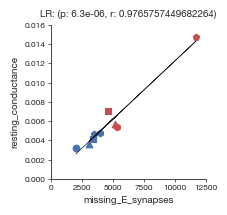

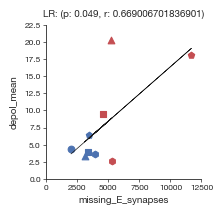

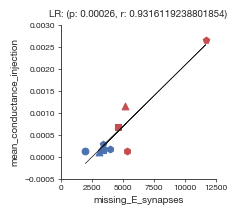

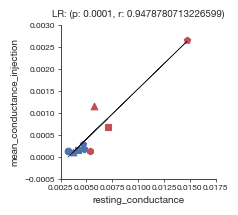

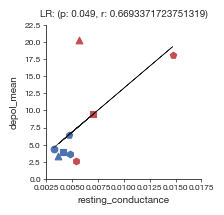

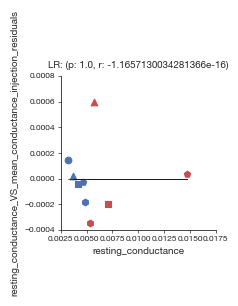

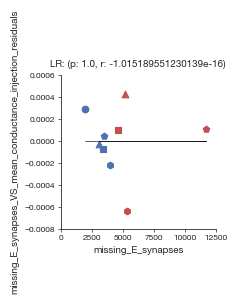

In [13]:
import pandas as pd
import matplotlib as mpl
# import cortex_etl as c_etl
import matplotlib.pyplot as plt
from scipy.stats import linregress


from math import log10, floor
round_to_n = lambda x, n: round(x, -int(floor(log10(x))) + (n - 1))

            
def plot_neuron_class_info_scatter(info_for_ncs, x_stat, y_stat):
    
    plt.figure(figsize=(2, 2))
    ax = plt.gca()
    
    for _, info_for_nc in info_for_ncs.iterrows():
        plt.scatter(info_for_nc[x_stat], info_for_nc[y_stat], c=info_for_nc['color'], marker=info_for_nc['marker'])
        
    lr = linregress(info_for_ncs[x_stat], info_for_ncs[y_stat])
    ax.set_title('LR: (p: ' + str(c_etl.round_to_n(lr.pvalue, 2)) + ', r: ' + str(lr.rvalue) + ')') # c_etl.round_to_n(, 2
    plt.plot(info_for_ncs[x_stat], lr.slope * info_for_ncs[x_stat] + lr.intercept, '-k', lw=0.5)
        
    mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
#     ax.set_xlabel(c_etl.label_for_key(x_stat), labelpad=-3)
#     ax.set_ylabel(c_etl.label_for_key(y_stat), labelpad=-8)
    
    ax.set_xlabel(x_stat)
    ax.set_ylabel(y_stat)
    ax.tick_params(axis='both', pad=2)
#     c_etl.remove_intermediate_labels(ax.xaxis.get_major_ticks())
#     c_etl.remove_intermediate_labels(ax.yaxis.get_major_ticks())

    plt.savefig(str(a.analysis_config['figures']) + '/' + x_stat + '_VS_' + y_stat + '.pdf', bbox_inches='tight')
    plt.show()
    plt.close()


def missing_synapses_analysis(a):
    
#     print("Compare depol parameters to missing synapses")
#     missing_E_synapses_by_neuron_class_df = pd.read_parquet('/gpfs/bbp.cscs.ch/project/proj147/home/isbister/blueetl_ji_1/blueetl_ji_analyses/data/missing_E_synapses_by_neuron_class.parquet')
#     input_conductance_by_neuron_class_df = pd.read_parquet('/gpfs/bbp.cscs.ch/project/proj147/home/isbister/blueetl_ji_1/blueetl_ji_analyses/data/input_conductance_by_neuron_class.parquet')
#     mean_depol_by_nc = a.custom['custom_features_by_neuron_class'].etl.q(neuron_class=c_etl.LAYER_EI_NEURON_CLASSES, window=a.custom['custom_features_by_neuron_class'].window.unique()[0]).loc[:,['depol_mean', 'neuron_class']].groupby(a.custom['custom_features_by_neuron_class'].neuron_class.astype(object)).mean().reset_index()  
    
#     info_for_nc = pd.merge(pd.merge(missing_E_synapses_by_neuron_class_df, input_conductance_by_neuron_class_df), mean_depol_by_nc)
#     info_for_nc['mean_conductance_injection'] = info_for_nc['resting_conductance'] * info_for_nc['depol_mean'] / 100.0
#     info_for_nc.loc[:, 'color'] = info_for_nc.apply(lambda row: c_etl.LAYER_EI_NEURON_CLASS_COLOURS[row['neuron_class']], axis = 1)
#     info_for_nc.loc[:, 'marker'] = info_for_nc.apply(lambda row: c_etl.LAYER_EI_NEURON_CLASS_MARKERS[row['neuron_class']], axis = 1)
    
    info_for_nc = pd.read_parquet(str(a.analysis_config['figures']) + "missing_input_df.parquet")
    
    plot_neuron_class_info_scatter(info_for_nc, 'missing_E_synapses', 'resting_conductance')
    plot_neuron_class_info_scatter(info_for_nc, 'missing_E_synapses', 'depol_mean')
    plot_neuron_class_info_scatter(info_for_nc, 'missing_E_synapses', 'mean_conductance_injection')
    plot_neuron_class_info_scatter(info_for_nc, 'resting_conductance', 'mean_conductance_injection')
    plot_neuron_class_info_scatter(info_for_nc, 'resting_conductance', 'depol_mean')
    
    lr = linregress(info_for_nc['resting_conductance'], info_for_nc['mean_conductance_injection'])
    info_for_nc.loc[:, 'resting_conductance_VS_mean_conductance_injection_residuals'] = info_for_nc['mean_conductance_injection'] - (info_for_nc['resting_conductance'] * lr.slope + lr.intercept)
    plot_neuron_class_info_scatter(info_for_nc, 'resting_conductance', 'resting_conductance_VS_mean_conductance_injection_residuals')
    
    lr = linregress(info_for_nc['missing_E_synapses'], info_for_nc['mean_conductance_injection'])
    info_for_nc.loc[:, 'missing_E_synapses_VS_mean_conductance_injection_residuals'] = info_for_nc['mean_conductance_injection'] - (info_for_nc['missing_E_synapses'] * lr.slope + lr.intercept)
    plot_neuron_class_info_scatter(info_for_nc, 'missing_E_synapses', 'missing_E_synapses_VS_mean_conductance_injection_residuals')
    
#     info_for_nc.to_parquet(str(a.analysis_config['figures']) + "missing_input_df.parquet")
    
    
missing_synapses_analysis(a)